In [1]:
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt

import keras
from keras.layers import LeakyReLU, UpSampling1D, Input, Reshape, Activation, Lambda, AveragePooling1D
from keras.layers import Convolution2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.models import load_model
import random

# From pypng
import png
#from sklearn.p

FONTSIZE = 18
FIGURE_SIZE = (10,4)
FIGURE_SIZE2 = (10,10)

# Configure parameters
plt.rcParams.update({'font.size': FONTSIZE})

####################################
# 
import re

##################
# Default tick label size
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24



Using TensorFlow backend.


In [2]:
#Function for generating list of images of respective parts.
def make_df(file, coloumn_name, code, new_coloumn_entry):
    image_names = []
    check_for = file[coloumn_name] == code
    file_data = file[check_for]
    file_data['Lesion_typename'] = new_coloumn_entry
    return(file_data)

#Function for generating training, validation and test sets list of images of respective parts.
def sets(image_names):
    train_length = len(image_names) * 0.7
    int_train_length = int(train_length)
    val_length = int_train_length + len(image_names) * 0.15
    int_val_length = int(val_length)
    trainset = image_names[:int_train_length]
    valset = image_names[int_train_length:int_val_length]
    testset = image_names[int_val_length:]
    return (trainset, valset, testset)

#Function for generating lists of imagenames and labels for trainset, valset and testset.
def make_list(Full_list, data_length):
    image_name = []
    image_label = []
    #Storing annotated image file names in a list (image_name).
    for i in range (data_length):
        image_name.append(Full_list['File_name'].values[i])
    #Storing annotated image label names in a list (image_label).
    for i in range (data_length):
        image_label.append(Full_list['Coarse_lesion_type'].values[i])
    return (image_name, image_label)

#Function for reading each image file and returning a 3-dimensional array.
def Read_image(image_name):
    read_image = png.Reader(image_name)
    image_copy = read_image.read()
    image_in_2d = np.vstack(map(np.uint8, image_copy[2]))
    image_in_3d = np.reshape(image_in_2d, (image_copy[0],image_copy[1],image_copy[3]['planes'])) / 512.0
    return image_in_3d

#Function for reading each image file from given directory using given image name list and returning a array.
def Image_directory(directory, image_name):
    print(directory, image_name)
    #Get all of the file names
    all_images = sorted(os.listdir(directory))
    list_of_images = [Read_image(directory + "/" + i) for i in all_images if re.search(image_name, i) ]    
    return np.array(list_of_images, dtype=np.float32)



In [3]:
#Function which takes measurement coordinates from csv file and compute mid-point of bounding box and height and width
def target_point(Measurement_coordinates):
    split_Mesur_list = []
    x_pt = []
    y_pt = []
    
    split_Mesur_list = Measurement_coordinates.split(', ')
    x_ind = [0, 2, 4, 6]
    y_ind = [1, 3, 5, 7]
    
    #List for respective coordinate points.
    for i in x_ind:
        x_pt.append(float(split_Mesur_list[i]))
    for j in y_ind:
        y_pt.append(float(split_Mesur_list[j]))
    
    #Height and width of bounding box
    height = max(y_pt) - min(y_pt)
    width = max(x_pt) - min(x_pt)
    
    #Mid point estimation.
    x_mid_1 = (x_pt[0] + x_pt[1])/2
    y_mid_1 = (y_pt[0] + y_pt[1])/2
    x_mid_2 = (x_pt[2] + x_pt[3])/2
    y_mid_2 = (y_pt[2] + y_pt[3])/2
    x_mid = (x_mid_1 + x_mid_2)/2
    y_mid = (y_mid_1 + y_mid_2)/2
    
    return x_mid, y_mid, height, width

#Function which takes measurement coordinates and grid size in number of pixels and returns target label of respective shape.
def gen_target(Measurement_coordinates, grid_size = 16):
    #Computing mid point, height and width of bounding box.
    x_mid, y_mid, height, width = target_point(Measurement_coordinates)
    #Total number of grids, using given grid size.
    grids = int(512/grid_size)
    
    #Locating grid which has midpoint.
    x_grid = int(x_mid/grid_size)
    y_grid = int(y_mid/grid_size)

    #mid points with respect to each grid
    x_mid_grid = (x_mid/grid_size) - x_grid
    y_mid_grid = (y_mid/grid_size) - y_grid
    
    #initializing target label as all zeros.
    target = np.zeros((grids,grids,5))
    #Defining and filling up list with "Pc", "bx", "by", "bh", and "bw"
    coord_list = []
    coord_list.append(1)
    coord_list.append(x_mid_grid)
    coord_list.append(y_mid_grid)
    coord_list.append(height)
    coord_list.append(width)
    
    #mid point located grid is filled with the above information.
    for i in range(len(coord_list)):
        target[x_grid][y_grid][i] = coord_list[i]
    
    return target

#Function for generating target labels for trainset, valset and testset.
def make_yolo(inlist, grid_size):
    image_name = []
    yolo_label = []
    data_length = inlist.shape[0]
    #Storing annotated image file names in a list (image_name).
    for i in range (data_length):
        image_name.append(inlist['File_name'].values[i])
    #Storing annotated image label names in a list (image_label).
    for i in range (data_length):
        Measurement_coordinates = inlist['Measurement_coordinates'].values[i]
        yolo_label.append(gen_target(Measurement_coordinates, grid_size))
    return (image_name, yolo_label)


In [5]:
#Reading file with file name and labels.

#Storing the images in directory.
directory = '/home2/potd0000/project/Key_slices/'

#data information extraction from csv file
Entire_image_list = pd.read_csv(r'/home2/potd0000/project/Dl_info.csv')
#Removing all other coloumns and only selecting Filename, Coarse_lesion_type and, Image_size to be there in dataframe.
list_filename_n_type = Entire_image_list[['File_name', 'Coarse_lesion_type', 'Image_size', 'Measurement_coordinates', 'Bounding_boxes', 'Lesion_diameters_Pixel_', 'Normalized_lesion_location']]

#Eliminating 40 image names which is not of size '512 x 512'
check_for_size = list_filename_n_type['Image_size'] == '512, 512'
list_filename_n_type = list_filename_n_type[check_for_size]

#Creating dataframes for each body parts.
Bone_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 1, 'Bone')
Abdomen_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 2, 'Abdomen')
Mediastinum_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 3, 'Mediastinum')
Liver_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 4, 'Liver')
Lung_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 5, 'Lung')
Kidney_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 6, 'Kidney')
Soft_tissue_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 7, 'Soft_tissue')
Pelvis_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 8, 'Pelvis')

#Creating train, validation and test sets.
trainset_Bone, valset_Bone, testset_Bone = sets(Bone_image_names)
trainset_Abdomen, valset_Abdomen, testset_Abdomen = sets(Abdomen_image_names)
trainset_Mediastinum, valset_Mediastinum, testset_Mediastinum = sets(Mediastinum_image_names)
trainset_Liver, valset_Liver, testset_Liver = sets(Liver_image_names)
trainset_Lung, valset_Lung, testset_Lung = sets(Lung_image_names)
trainset_Kidney, valset_Kidney, testset_Kidney = sets(Kidney_image_names)
trainset_Soft_tissue, valset_Soft_tissue, testset_Soft_tissue = sets(Soft_tissue_image_names)
trainset_Pelvis, valset_Pelvis, testset_Pelvis = sets(Pelvis_image_names)



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
#Creating yolo label and respective image name list.
yolo_train_lung_ins, yolo_train_lung_outs = make_yolo(trainset_Lung, 32)
yolo_val_lung_ins, yolo_val_lung_outs = make_yolo(valset_Lung, 32)
yolo_test_lung_ins, yolo_test_lung_outs = make_yolo(testset_Lung, 32)


In [6]:

train_image_data_list = []
yolo_train_lung_ins1 = yolo_train_lung_ins
for names in yolo_train_lung_ins1:
    train_image_data_list.extend(Image_directory(directory, names))
input_train_image = np.array(train_image_data_list)
input_train_image.shape


/home2/potd0000/project/Key_slices/ 000004_02_02_073.png
/home2/potd0000/project/Key_slices/ 000004_02_02_145.png
/home2/potd0000/project/Key_slices/ 000004_03_02_136.png
/home2/potd0000/project/Key_slices/ 000009_04_02_022.png
/home2/potd0000/project/Key_slices/ 000009_04_03_101.png
/home2/potd0000/project/Key_slices/ 000013_01_01_044.png
/home2/potd0000/project/Key_slices/ 000020_03_01_134.png
/home2/potd0000/project/Key_slices/ 000020_03_01_212.png
/home2/potd0000/project/Key_slices/ 000020_03_01_166.png
/home2/potd0000/project/Key_slices/ 000020_04_01_159.png
/home2/potd0000/project/Key_slices/ 000020_04_01_116.png
/home2/potd0000/project/Key_slices/ 000020_04_01_143.png
/home2/potd0000/project/Key_slices/ 000026_06_01_165.png
/home2/potd0000/project/Key_slices/ 000026_06_01_257.png
/home2/potd0000/project/Key_slices/ 000027_03_01_095.png
/home2/potd0000/project/Key_slices/ 000027_04_01_119.png
/home2/potd0000/project/Key_slices/ 000027_05_01_099.png
/home2/potd0000/project/Key_sli

(1673, 512, 512, 3)

In [13]:
np.save('yolo_lung_input_train_image_data', input_train_image)

In [ ]:
yolo_lung_input_train_image_saved = np.load('yolo_lung_input_train_image_data.npy')

In [7]:

val_image_data_list = []
yolo_val_lung_ins1 = yolo_val_lung_ins
for names in yolo_val_lung_ins1:
    val_image_data_list.extend(Image_directory(directory, names))
input_val_image = np.array(val_image_data_list)
input_val_image.shape

/home2/potd0000/project/Key_slices/ 003171_04_01_135.png
/home2/potd0000/project/Key_slices/ 003171_04_01_088.png
/home2/potd0000/project/Key_slices/ 003171_05_01_080.png
/home2/potd0000/project/Key_slices/ 003171_05_01_080.png
/home2/potd0000/project/Key_slices/ 003171_05_01_133.png
/home2/potd0000/project/Key_slices/ 003171_05_01_091.png
/home2/potd0000/project/Key_slices/ 003171_06_01_073.png
/home2/potd0000/project/Key_slices/ 003171_06_01_166.png
/home2/potd0000/project/Key_slices/ 003171_06_01_076.png
/home2/potd0000/project/Key_slices/ 003171_06_01_071.png
/home2/potd0000/project/Key_slices/ 003171_06_01_126.png
/home2/potd0000/project/Key_slices/ 003171_06_01_082.png
/home2/potd0000/project/Key_slices/ 003171_06_01_124.png
/home2/potd0000/project/Key_slices/ 003171_06_01_066.png
/home2/potd0000/project/Key_slices/ 003171_06_01_077.png
/home2/potd0000/project/Key_slices/ 003171_07_01_090.png
/home2/potd0000/project/Key_slices/ 003171_07_01_093.png
/home2/potd0000/project/Key_sli

(358, 512, 512, 3)

In [33]:
np.save('yolo_lung_input_val_image_data', input_val_image)

In [7]:
yolo_lung_input_val_image_saved = np.load('yolo_lung_input_val_image_data.npy')

In [8]:

test_image_data_list = []
yolo_test_lung_ins1 = yolo_test_lung_ins

for names in yolo_test_lung_ins1:
    test_image_data_list.extend(Image_directory(directory, names))
input_test_image = np.array(test_image_data_list)
input_test_image.shape

/home2/potd0000/project/Key_slices/ 003580_11_01_148.png
/home2/potd0000/project/Key_slices/ 003580_11_01_109.png
/home2/potd0000/project/Key_slices/ 003580_12_01_186.png
/home2/potd0000/project/Key_slices/ 003580_12_01_192.png
/home2/potd0000/project/Key_slices/ 003581_01_01_047.png
/home2/potd0000/project/Key_slices/ 003581_01_03_199.png
/home2/potd0000/project/Key_slices/ 003599_01_02_232.png
/home2/potd0000/project/Key_slices/ 003599_03_02_252.png
/home2/potd0000/project/Key_slices/ 003602_01_02_490.png
/home2/potd0000/project/Key_slices/ 003602_01_02_280.png
/home2/potd0000/project/Key_slices/ 003602_01_02_874.png
/home2/potd0000/project/Key_slices/ 003612_01_01_177.png
/home2/potd0000/project/Key_slices/ 003612_02_01_174.png
/home2/potd0000/project/Key_slices/ 003613_01_02_105.png
/home2/potd0000/project/Key_slices/ 003616_01_01_259.png
/home2/potd0000/project/Key_slices/ 003634_01_02_170.png
/home2/potd0000/project/Key_slices/ 003635_01_01_191.png
/home2/potd0000/project/Key_sli

(359, 512, 512, 3)

#### test_image_data_list = []

for names in yolo_test_lung_ins:
    test_image_data_list.extend(Image_directory(directory, names))
input_test_image = np.array(test_image_data_list)
input_test_image.shape

In [35]:
np.save('yolo_lung_input_test_image_data', input_test_image)

In [8]:
yolo_lung_input_test_image_saved = np.load('yolo_lung_input_test_image_data.npy')

In [11]:
ins = input_train_image
#ins = input_val_image
outs = np.array(yolo_train_lung_outs)
ins_validation = input_val_image
outs_validation = np.array(yolo_val_lung_outs)
ins_test = input_test_image
outs_test = np.array(yolo_test_lung_outs)

In [31]:
#Constructing Network

#we are using three 2D convolution layers each with 100, 200, 300, 400, 500, 600, 700, 800 filters.
#we are using 2D transpose convolution layers with 600, 300, 100, 50, 10 filters.
#For final output we are using 2D convolution layer with 5 filters.
#I am using regularization with value 0
#To bring down the number of parameters, I am using 1 x 1 strides in two Maxpooling layers.

def construct_model(input_shape, lambda_regularization = 0):
    model = Sequential()
    
    model.add(Convolution2D(filters = 10,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C0'))
    
    model.add(Convolution2D(filters = 10,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C1'))
    
    model.add(Convolution2D(filters = 10,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C2'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C3'))
    
    model.add(Convolution2D(filters = 20,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C4'))
    
    model.add(Convolution2D(filters = 20,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C5'))

    model.add(Convolution2D(filters = 20,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C6'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C7'))

    model.add(Convolution2D(filters = 30,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C8'))

    model.add(Convolution2D(filters = 30,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C9'))

    model.add(Convolution2D(filters = 30,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C10'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C11'))
    
    model.add(Convolution2D(filters = 40,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C12'))
    
    model.add(Convolution2D(filters = 40,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C13'))
    
    model.add(Convolution2D(filters = 40,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C14'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C15'))
    
    model.add(Convolution2D(filters = 50,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C16'))
    
    model.add(Convolution2D(filters = 50,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C17'))
    
    model.add(Convolution2D(filters = 50,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C18'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C19'))
    
    model.add(Convolution2D(filters = 60,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C20'))
    
    model.add(Convolution2D(filters = 60,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C21'))
    
    model.add(Convolution2D(filters = 60,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C22'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C23'))
    
    model.add(Convolution2D(filters = 70,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C24'))
    
    model.add(Convolution2D(filters = 70,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C25'))
    
    model.add(Convolution2D(filters = 70,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C26'))
    
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), name = 'C27'))
    
    model.add(Convolution2D(filters = 80,
                           input_shape = input_shape,
                           kernel_size = (3, 3),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C28'))
    
    model.add(Conv2DTranspose(filters = 60,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C29'))
    
    model.add(Conv2DTranspose(filters = 30,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C30'))
    
    model.add(Conv2DTranspose(filters = 10,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C31'))
        
    model.add(Conv2DTranspose(filters = 10,
                           input_shape = input_shape,
                           kernel_size = (5, 5),
                           strides = 2,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'relu',
                           name = 'C32'))

    model.add(Convolution2D(filters = 5,
                           input_shape = input_shape,
                           kernel_size = (1, 1),
                           strides = 1,
                           padding = 'same',
                           use_bias = True,
                           kernel_initializer = 'random_uniform',
                           bias_initializer = 'random_uniform',
                           kernel_regularizer = keras.regularizers.l2(lambda_regularization),
                           bias_regularizer = keras.regularizers.l2(lambda_regularization),
                           activation = 'linear',
                           name = 'output'))
        
    
    # The optimizer determines how the gradient descent is to be done
    opt = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, 
                            epsilon = None, decay = 0.0, amsgrad = False)
    
    model.compile(loss = 'binary_crossentropy', optimizer = opt, 
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [32]:
model = construct_model(ins.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C0 (Conv2D)                  (None, 256, 256, 10)      280       
_________________________________________________________________
C1 (Conv2D)                  (None, 256, 256, 10)      2510      
_________________________________________________________________
C2 (Conv2D)                  (None, 256, 256, 10)      910       
_________________________________________________________________
C3 (MaxPooling2D)            (None, 254, 254, 10)      0         
_________________________________________________________________
C4 (Conv2D)                  (None, 127, 127, 20)      1820      
_________________________________________________________________
C5 (Conv2D)                  (None, 127, 127, 20)      10020     
_________________________________________________________________
C6 (Conv2D)                  (None, 127, 127, 20)      3620      
__________

In [33]:
def training_set_generator(ins, outs, batch_size = 10,
                      input_name = 'input_input', 
                      output_name = 'output'):
    while True:
        example_indices = random.choices(range(ins.shape[0]), k=batch_size)
        yield({input_name: ins[example_indices,:,:,:]},
             {output_name: outs[example_indices]})


In [34]:
generator = training_set_generator(ins,outs, batch_size = 100, 
                                  input_name = 'C0_input')

#Stopping criteria for epoch termination with patience = 10
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                               min_delta = 0, patience = 10, 
                                               verbose = 0, mode = 'auto', 
                                               baseline = None, 
                                               restore_best_weights = True)

#Total training set has 1673 images and batch size is 100.
#Hence 18 steps per epoch will cover entire training dataset.
model.fit_generator(generator, epochs = 150, steps_per_epoch = 17, 
                    validation_data=(ins_validation, outs_validation))

Epoch 1/150
17/17 [==============================] - 166s 10s/step - loss: 0.3425 - acc: 0.9961 - val_loss: 0.2937 - val_acc: 0.9961
Epoch 2/150
17/17 [==============================] - 148s 9s/step - loss: 0.3507 - acc: 0.9961 - val_loss: 0.2912 - val_acc: 0.9961
Epoch 3/150
17/17 [==============================] - 146s 9s/step - loss: 0.3487 - acc: 0.9961 - val_loss: 0.2890 - val_acc: 0.9961
Epoch 4/150
17/17 [==============================] - 144s 8s/step - loss: 0.3286 - acc: 0.9961 - val_loss: 0.2871 - val_acc: 0.9961
Epoch 5/150
17/17 [==============================] - 145s 9s/step - loss: 0.3324 - acc: 0.9961 - val_loss: 0.2852 - val_acc: 0.9961
Epoch 6/150
17/17 [==============================] - 146s 9s/step - loss: 0.3279 - acc: 0.9961 - val_loss: 0.2830 - val_acc: 0.9961
Epoch 7/150
17/17 [==============================] - 145s 9s/step - loss: 0.3308 - acc: 0.9961 - val_loss: 0.2800 - val_acc: 0.9961
Epoch 8/150
17/17 [==============================] - 147s 9s/step - loss: 0

In [75]:
model.save('yolo_model_bhairav-2.h5')

In [9]:
model = keras.models.load_model('yolo_model_bhairav-2.h5')

In [19]:
pred = model.predict(ins_validation)

In [13]:
def max_from_out(x, grids):
    new_x = np.zeros((grids, grids))
    for i in range (grids):
        for j in range (grids):
            new_x[i][j] = x[i][j][0]
    max_pos = np.where(new_x == np.amax(new_x))
    return max_pos

In [22]:
i = 0
predicted_pos = max_from_out(pred[i], 16)
actual_pos = max_from_out(outs_validation[i], 16)
print("Predicted Position: ", predicted_pos)
print("Actual Position: ", actual_pos)

Predicted Position:  (array([0]), array([0]))
Actual Position:  (array([5]), array([5]))


In [17]:
pred[0]

array([[[-0.00436741,  0.00367001, -0.00820366,  0.01063255,
         -0.0238407 ],
        [-0.07512186, -0.004262  , -0.01883652, -0.00516189,
         -0.02542182],
        [-0.04597349, -0.00394595, -0.02173928,  0.00435158,
         -0.02523252],
        ...,
        [-0.12932664, -0.00761511, -0.03437801,  0.00122316,
         -0.0393074 ],
        [-0.05730436, -0.00135959, -0.01553894,  0.00786636,
         -0.01501578],
        [-0.04093071,  0.00137529, -0.01752642,  0.01092358,
         -0.01911359]],

       [[-0.01033666,  0.00199728, -0.0124147 ,  0.01337063,
         -0.02947116],
        [-0.06111134, -0.00384695, -0.03792144,  0.00225836,
         -0.03738999],
        [-0.07948706, -0.0178356 , -0.03529828, -0.01879698,
         -0.03737085],
        ...,
        [-0.19790797, -0.0082391 , -0.08854923,  0.01127789,
         -0.0325333 ],
        [-0.07538737, -0.02166468, -0.04418742, -0.00244461,
         -0.02502454],
        [-0.07028665, -0.0140128 , -0.04453352, 

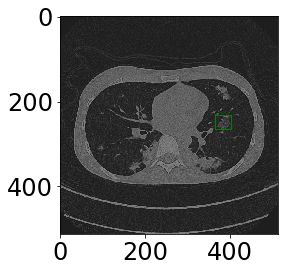

In [27]:
plt.imshow(ins_test[0])

In [173]:
def viz_layers(model, image):
    image_batch = np.expand_dims(image, axis = 0)
    conv_image2 = model.predict(image_batch)
    
    conv_image2 = np.squeeze(conv_image2, axis = 0)
    print(conv_image2.shape)
    #conv_image2 = conv_image2.reshape(conv_image2.shape[:2])
    #print(conv_image2.shape)
    plt.imshow(conv_image2)

In [186]:
model = Sequential()
    
model.add(Convolution2D(filters = 3,
                        input_shape = ins.shape[1:],
                        kernel_size = (11, 11)))

model.add(Convolution2D(filters = 3,
                        kernel_size = (10, 10)))

model.add(MaxPooling2D(pool_size = (8, 8), strides = (1, 1)))

model.add(Convolution2D(filters = 3,
                        kernel_size = (6, 6)))

model.add(MaxPooling2D(pool_size = (8, 8), strides = (1, 1)))

model.add(Convolution2D(filters = 3,
                        kernel_size = (10, 10)))

model.add(Convolution2D(filters = 3,
                        kernel_size = (6, 6)))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(460, 460, 3)


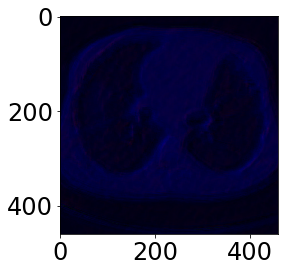

In [187]:
viz_layers(model, ins[1])

In [39]:
def intermediate_model_state(model, ins, layer_list):
    '''
    Return layer activations for intermediate layers in a model for a set of examples
    
    :param model: Model in question
    :param ins: Input tensor (examples, rows, cols, channels)
    :param layer_list: List of layer names to produce activations for
    :returns: a list of numpy arrays
    '''
    # Translate layer names into corresponding output tensors
    layer_outputs = [l.output for l in model.layers if l.name in layer_list]
    
    # Construct a new Keras model that outputs these tensors
    new_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
    
    # Evaluate the new model
    activations = new_model.predict(ins)
    
    # Return a list of activation numpy arrays
    return activations

def visualize_state(activations, width=1, example=0, cmap='plasma'):
    '''
    Produce graphical representation of a set of image channels
    
    :param activations: numpy array (example, rows, cols, channels)
    :param width: Number of images displayed horizontally
    :param example: Index of example to display
    :param cmap: Color map to use for plotting
    '''
    # Size of the individual images
    nrows = activations.shape[1]
    ncols = activations.shape[2]
    # Number of channels
    nfilters = activations.shape[3]
    
    # Space tile all of the images into
    grid = np.zeros((int((nfilters-1)/width + 1) * nrows, ncols * width))
    
    # Loop over image
    for i in range(nfilters):
        # Compute r,c of tile to place the ith image into
        r = int(i / width)
        c = i % width
        grid[nrows*r: nrows*(r+1), ncols*c:ncols*(c+1)] = activations[example,:,:,i]
        
    # Plot
    plt.matshow(grid, cmap=cmap) 


## USAGE
#layer_list=['C1_ACT', 'C2_ACT', 'C3_ACT']
#activations = intermediate_model_state(model, ins_validation, layer_list)
#example=5
#plt.imshow(ins_validation[example,:,:,:])
#visualize_state(activations[0], width=10, example=example)
#visualize_state(activations[1], width=20, example=example)
#visualize_state(activations[2], width=30, example=example)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


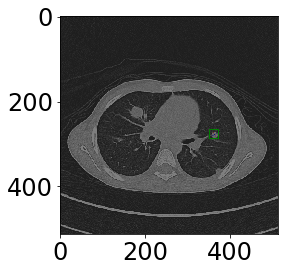

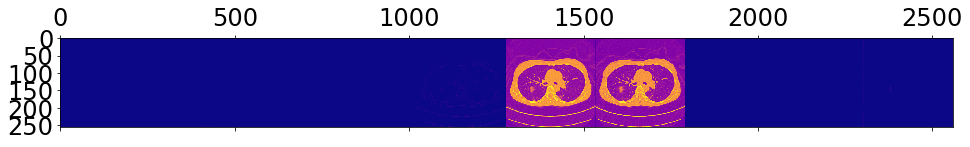

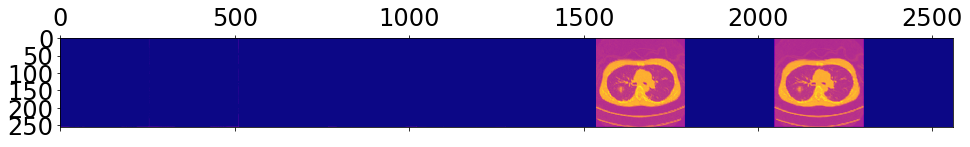

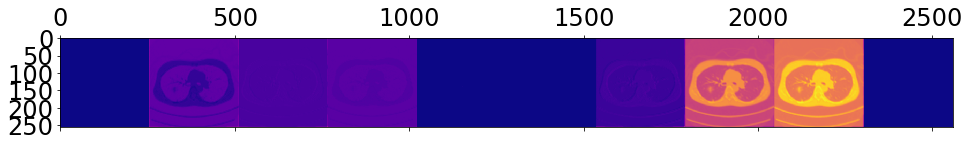

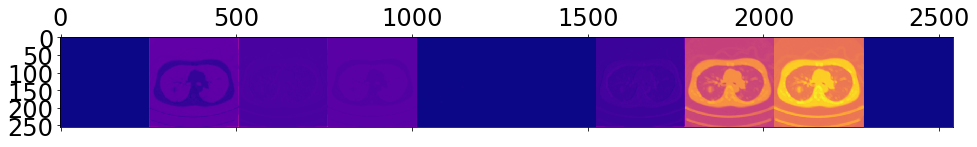

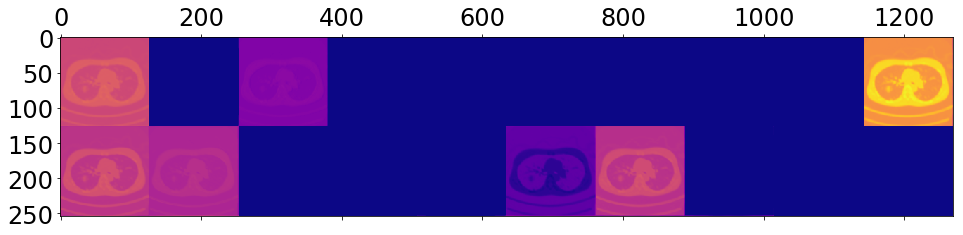

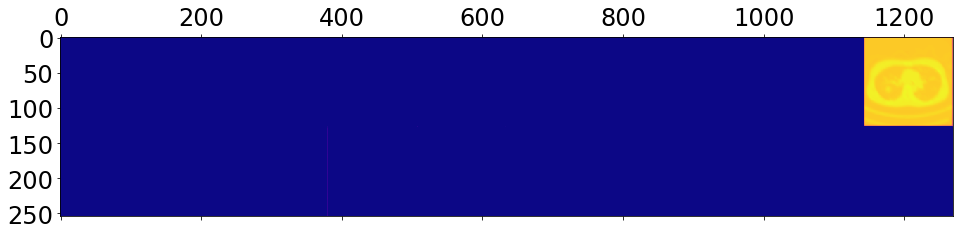

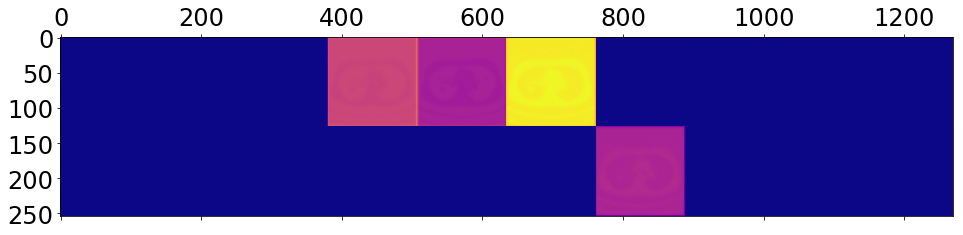

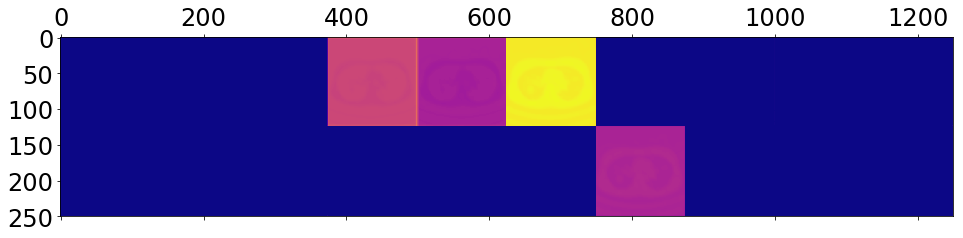

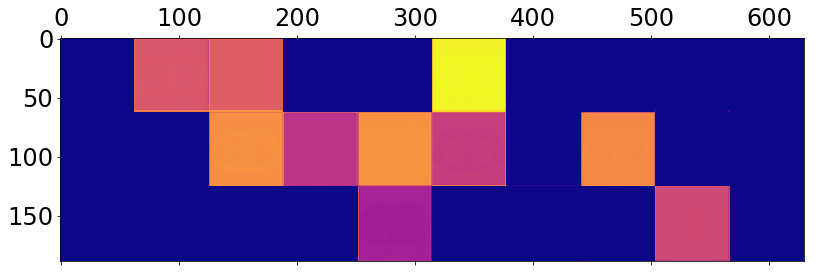

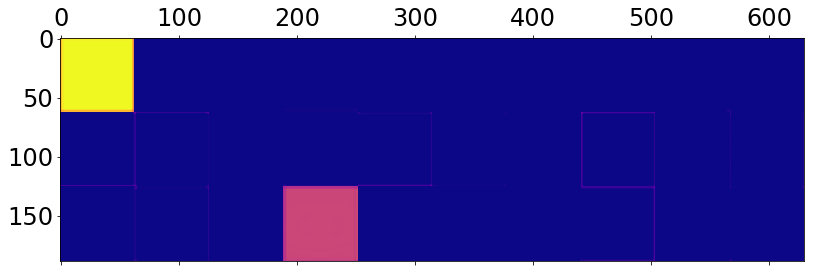

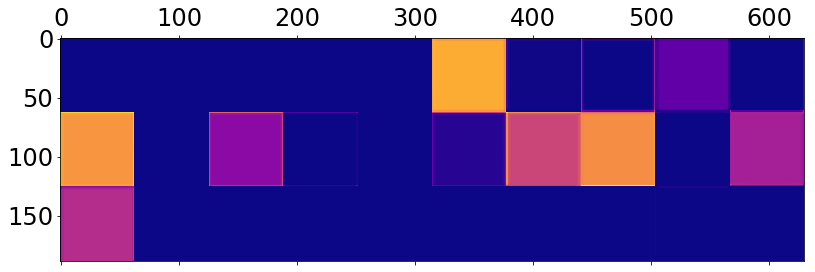

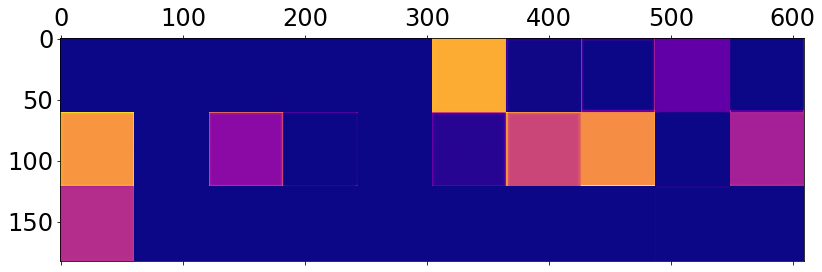

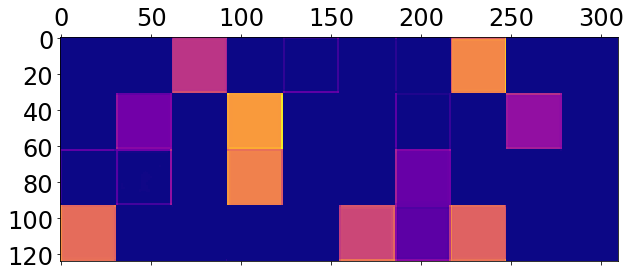

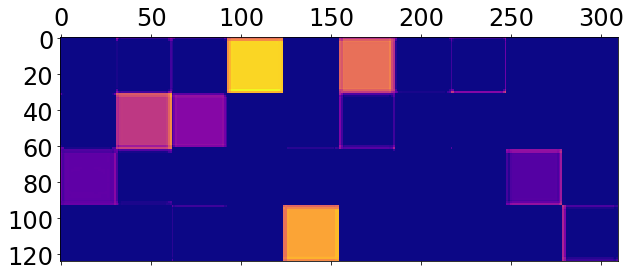

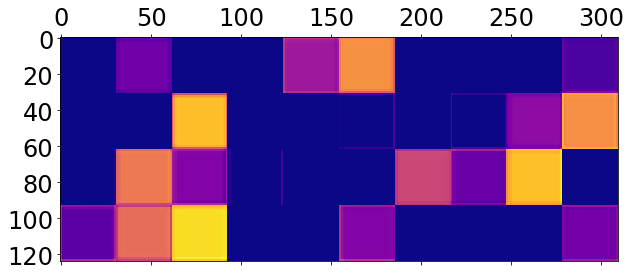

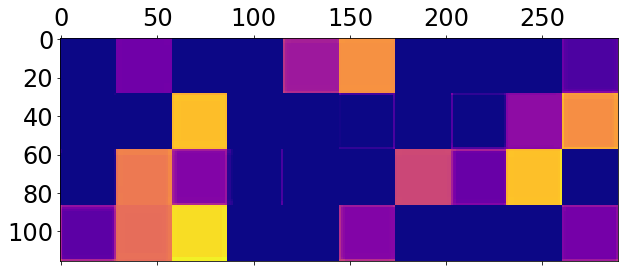

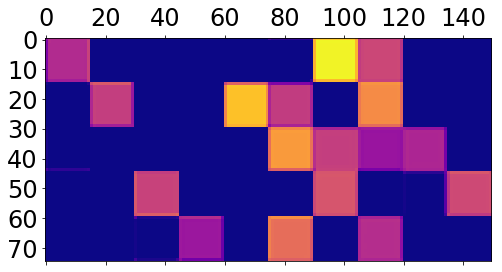

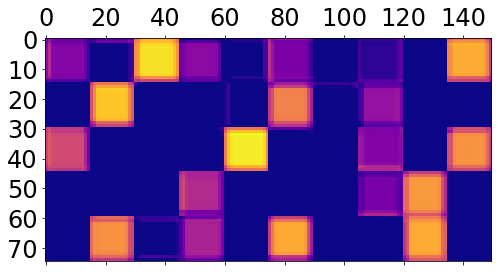

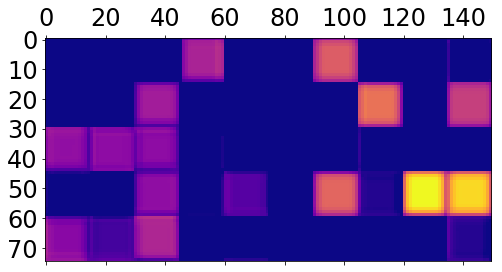

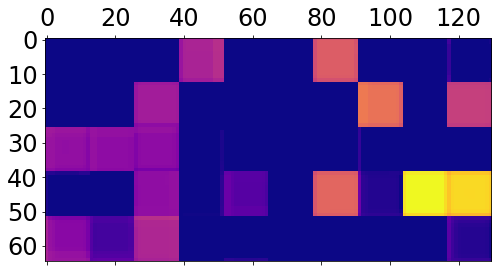

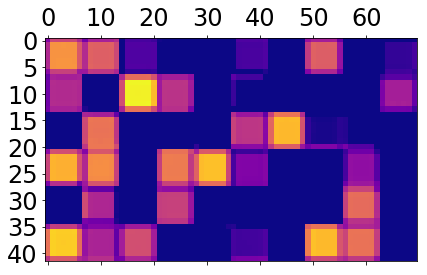

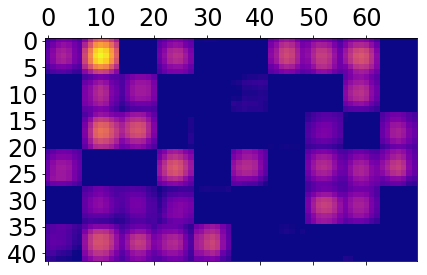

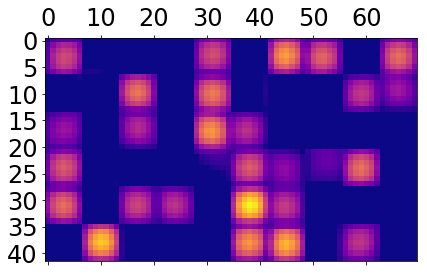

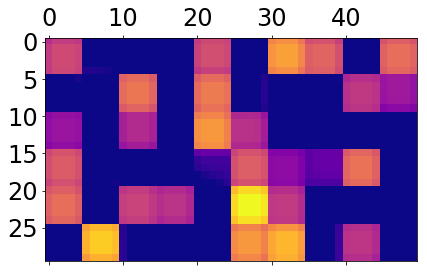

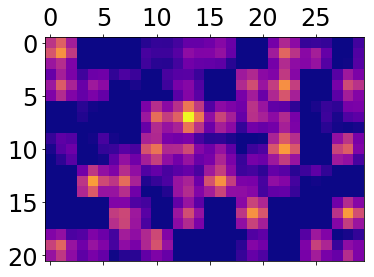

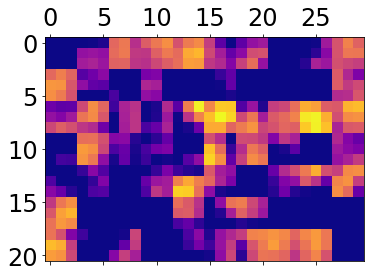

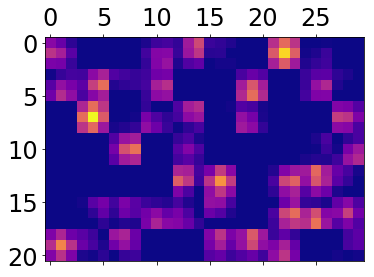

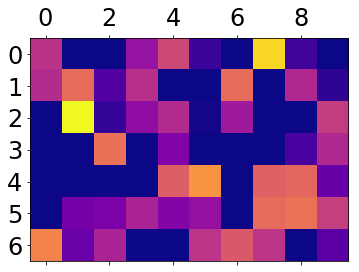

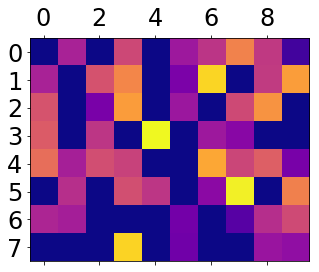

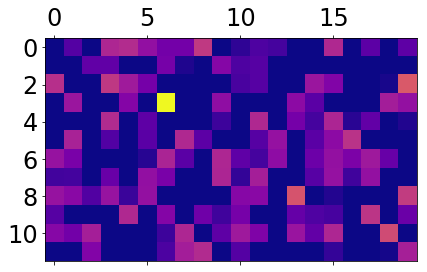

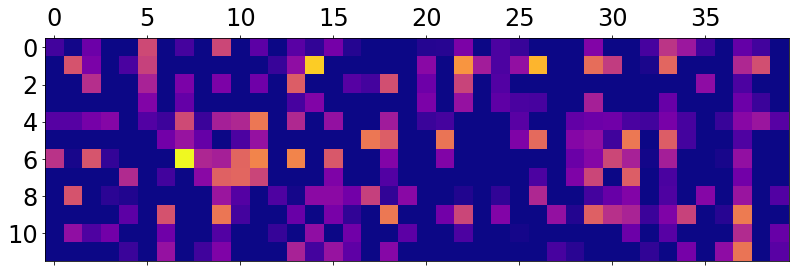

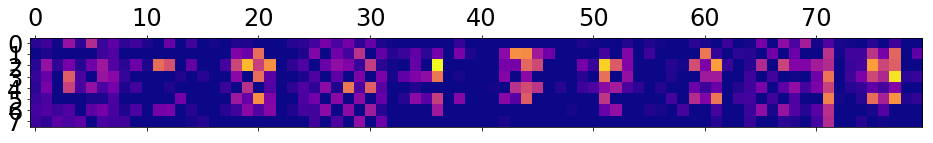

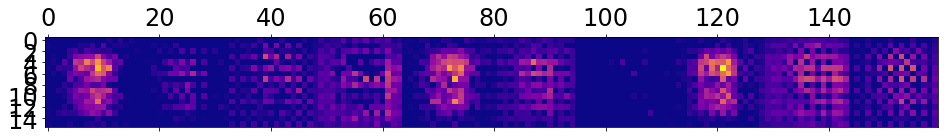

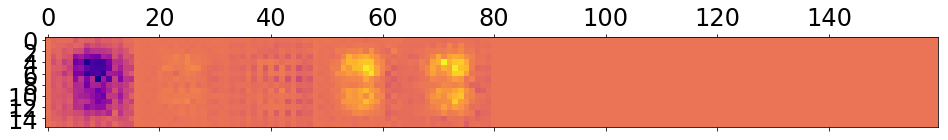

In [42]:
layer_list=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 
            'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'output']
activations = intermediate_model_state(model, ins_test, layer_list)
example = 1
plt.imshow(ins_validation[example,:,:,:])
for i in range (len(layer_list)):
    visualize_state(activations[i], width = 10, example = example)

In [ ]:
""""
visualize_state(activations[1], width=10, example=example)
visualize_state(activations[2], width=10, example=example)
visualize_state(activations[3], width=10, example=example)
visualize_state(activations[4], width=10, example=example)
visualize_state(activations[5], width=10, example=example)
visualize_state(activations[6], width=10, example=example)
visualize_state(activations[7], width=10, example=example)
visualize_state(activations[8], width=10, example=example)
visualize_state(activations[9], width=10, example=example)
visualize_state(activations[10], width=10, example=example)
visualize_state(activations[11], width=10, example=example)
visualize_state(activations[12], width=10, example=example)
visualize_state(activations[13], width=10, example=example)
visualize_state(activations[14], width=10, example=example)
visualize_state(activations[15], width=10, example=example)
visualize_state(activations[0], width=10, example=example)
visualize_state(activations[1], width=10, example=example)
visualize_state(activations[2], width=10, example=example)
visualize_state(activations[3], width=10, example=example)
visualize_state(activations[4], width=10, example=example)
visualize_state(activations[5], width=10, example=example)
visualize_state(activations[6], width=10, example=example)
visualize_state(activations[7], width=10, example=example)
visualize_state(activations[8], width=10, example=example)
visualize_state(activations[9], width=10, example=example)
visualize_state(activations[10], width=10, example=example)
visualize_state(activations[11], width=10, example=example)
visualize_state(activations[12], width=10, example=example)
visualize_state(activations[13], width=10, example=example)
visualize_state(activations[14], width=10, example=example)
visualize_state(activations[15], width=10, example=example)
""""